In [48]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

digits = datasets.load_digits()

scaler = StandardScaler()
scaler.fit(digits.data)
x = scaler.transform(digits.data)
y = digits.target

print(y[:1])
print(x[:1])

[0]
[[ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751 -0.84412939
  -0.40972392 -0.12502292 -0.05907756 -0.62400926  0.4829745   0.75962245
  -0.05842586  1.12772113  0.87958306 -0.13043338 -0.04462507  0.11144272
   0.89588044 -0.86066632 -1.14964846  0.51547187  1.90596347 -0.11422184
  -0.03337973  0.48648928  0.46988512 -1.49990136 -1.61406277  0.07639777
   1.54181413 -0.04723238  0.          0.76465553  0.05263019 -1.44763006
  -1.73666443  0.04361588  1.43955804  0.         -0.06134367  0.8105536
   0.63011714 -1.12245711 -1.06623158  0.66096475  0.81845076 -0.08874162
  -0.03543326  0.74211893  1.15065212 -0.86867056  0.11012973  0.53761116
  -0.75743581 -0.20978513 -0.02359646 -0.29908135  0.08671869  0.20829258
  -0.36677122 -1.14664746 -0.5056698  -0.19600752]]


In [49]:
import torch
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=360, random_state=42)

train_x = torch.FloatTensor(train_x)
train_y = torch.LongTensor(train_y)
val_x = torch.FloatTensor(val_x)
val_y = torch.LongTensor(val_y)
test_x = torch.FloatTensor(test_x)
test_y = torch.LongTensor(test_y)

print(train_x.size())
print(train_y.size())
print(val_x.size())
print(val_y.size())
print(test_x.size())
print(test_y.size())

torch.Size([1077, 64])
torch.Size([1077])
torch.Size([360, 64])
torch.Size([360])
torch.Size([360, 64])
torch.Size([360])


In [50]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [51]:
from torch import nn
from torchinfo import summary

model = nn.Sequential(
    nn.Linear(64, 100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.Sigmoid(),
    nn.Linear(50, 10),
)

print(summary(model, input_size=(1, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Linear: 1-1                            [1, 100]                  6,500
├─Sigmoid: 1-2                           [1, 100]                  --
├─Linear: 1-3                            [1, 50]                   5,050
├─Sigmoid: 1-4                           [1, 50]                   --
├─Linear: 1-5                            [1, 10]                   510
Total params: 12,060
Trainable params: 12,060
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05


In [52]:
def uniform_init_parameters(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)
        nn.init.uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(uniform_init_parameters)

Sequential(
  (0): Linear(in_features=64, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1)

In [54]:
import torch

def fit_model(model, loss_fn, optimizer, epochs=100):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    step1 = epochs / 10

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # 前向传播
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 统计
            running_loss += loss.item() # loss.item()返回的是一个标量，是一个batch的平均loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 计算训练指标
        train_loss = running_loss / len(train_loader) # len(train_loader)返回的是batch的个数
        train_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 验证阶段
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1) # torch.max返回的是最大值和最大值的索引
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # 计算验证指标
        test_loss = test_loss / len(val_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)


        if (epoch + 1) % step1 == 0:
            print(f"Epoch {epoch+1} / {epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                  f"Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy:.2f}%")

    # 打印最终结果
    print("\nTraining complete!")
    print(f"Best Test Accuracy: {max(test_accuracies):.2f}% at epoch {test_accuracies.index(max(test_accuracies))+1}")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': test_losses,
        'val_accuracies': test_accuracies
    }

In [55]:
result = fit_model(model, loss_fn, optimizer, epochs=200)

Epoch 20 / 200: Train Loss: 3.6156, Train Acc: 28.04%, Val Loss: 4.7397, Val Acc: 32.50%
Epoch 40 / 200: Train Loss: 0.4450, Train Acc: 87.93%, Val Loss: 1.0631, Val Acc: 78.06%
Epoch 60 / 200: Train Loss: 0.0423, Train Acc: 99.35%, Val Loss: 0.2177, Val Acc: 93.61%
Epoch 80 / 200: Train Loss: 0.0226, Train Acc: 99.63%, Val Loss: 0.2479, Val Acc: 92.78%
Epoch 100 / 200: Train Loss: 0.0135, Train Acc: 99.81%, Val Loss: 0.2457, Val Acc: 93.06%
Epoch 120 / 200: Train Loss: 0.0135, Train Acc: 99.72%, Val Loss: 0.2329, Val Acc: 94.17%
Epoch 140 / 200: Train Loss: 0.0076, Train Acc: 99.81%, Val Loss: 0.2382, Val Acc: 94.17%
Epoch 160 / 200: Train Loss: 0.0046, Train Acc: 100.00%, Val Loss: 0.2384, Val Acc: 94.17%
Epoch 180 / 200: Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.2448, Val Acc: 93.89%
Epoch 200 / 200: Train Loss: 0.0028, Train Acc: 100.00%, Val Loss: 0.2468, Val Acc: 94.17%

Training complete!
Best Test Accuracy: 94.44% at epoch 125


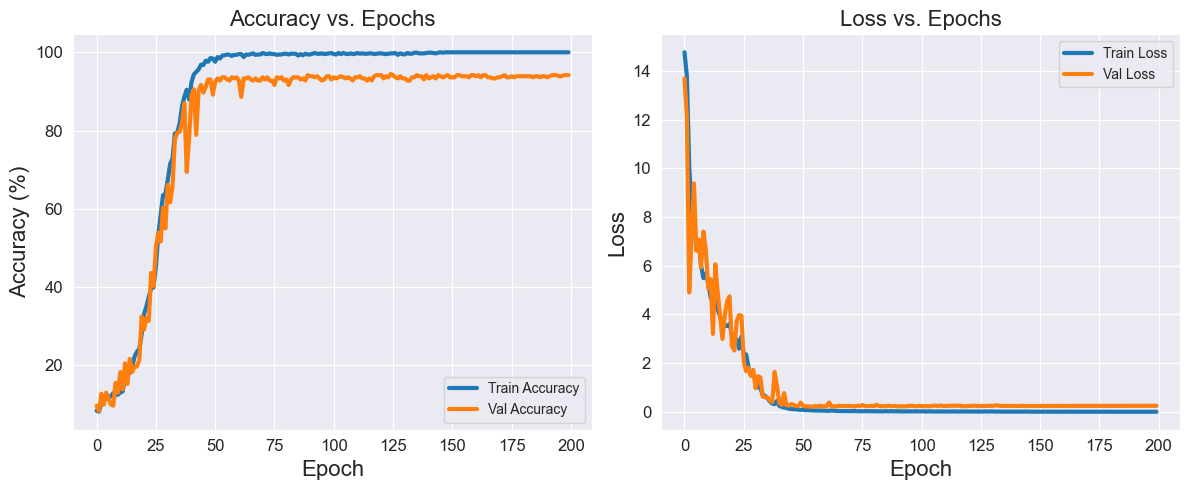

In [56]:
import matplotlib.pyplot as plt

def plot_results(result):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result['train_accuracies'], label='Train Accuracy', linewidth=3)
    plt.plot(result['val_accuracies'], label='Val Accuracy', linewidth=3)
    plt.title('Accuracy vs. Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(result['train_losses'], label='Train Loss', linewidth=3)
    plt.plot(result['val_losses'], label='Val Loss', linewidth=3)
    plt.title('Loss vs. Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(result)

In [57]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

test_accuracy = evaluate_model(model, test_loader)

Test Accuracy: 92.50%


Epoch 20 / 200: Train Loss: 2.3374, Train Acc: 28.88%, Val Loss: 2.2169, Val Acc: 23.06%
Epoch 40 / 200: Train Loss: 0.4294, Train Acc: 87.00%, Val Loss: 0.6137, Val Acc: 80.83%
Epoch 60 / 200: Train Loss: 0.0716, Train Acc: 98.51%, Val Loss: 0.3034, Val Acc: 90.28%
Epoch 80 / 200: Train Loss: 0.0329, Train Acc: 99.44%, Val Loss: 0.2800, Val Acc: 91.67%
Epoch 100 / 200: Train Loss: 0.0176, Train Acc: 99.81%, Val Loss: 0.3269, Val Acc: 91.11%
Epoch 120 / 200: Train Loss: 0.0146, Train Acc: 99.81%, Val Loss: 0.2958, Val Acc: 91.67%
Epoch 140 / 200: Train Loss: 0.0118, Train Acc: 99.81%, Val Loss: 0.2934, Val Acc: 91.39%
Epoch 160 / 200: Train Loss: 0.0085, Train Acc: 99.91%, Val Loss: 0.3144, Val Acc: 91.94%
Epoch 180 / 200: Train Loss: 0.0039, Train Acc: 100.00%, Val Loss: 0.3172, Val Acc: 91.94%
Epoch 200 / 200: Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.3189, Val Acc: 91.94%

Training complete!
Best Test Accuracy: 92.50% at epoch 75


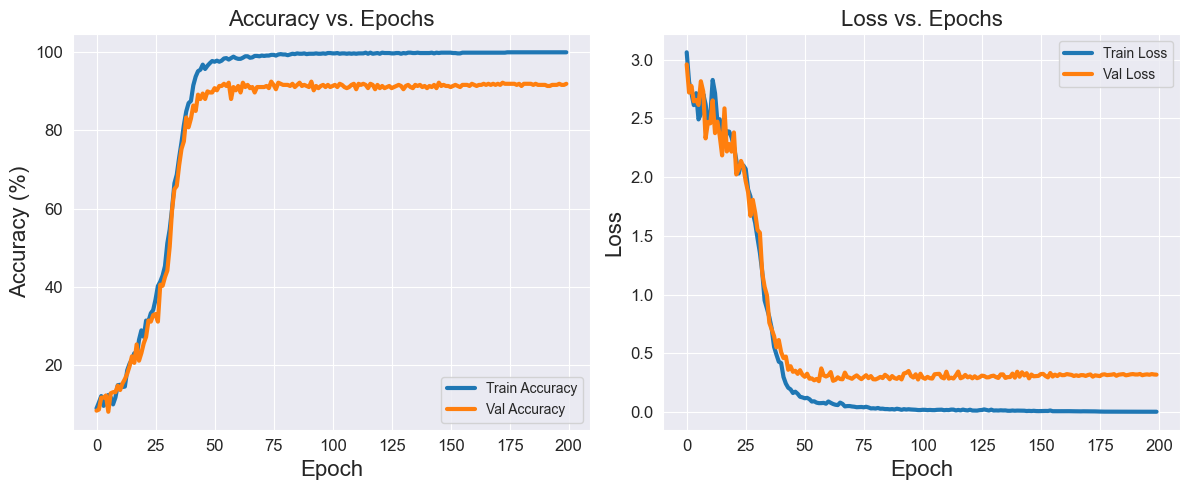

In [58]:
model.apply(uniform_init_parameters)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
result = fit_model(model, loss_fn, optimizer, epochs=200)
plot_results(result)

Epoch 20 / 200: Train Loss: 0.0879, Train Acc: 98.79%, Val Loss: 0.2252, Val Acc: 93.61%
Epoch 40 / 200: Train Loss: 0.0383, Train Acc: 99.63%, Val Loss: 0.1765, Val Acc: 95.56%
Epoch 60 / 200: Train Loss: 0.0243, Train Acc: 99.72%, Val Loss: 0.1628, Val Acc: 95.00%
Epoch 80 / 200: Train Loss: 0.0174, Train Acc: 99.81%, Val Loss: 0.1604, Val Acc: 95.28%
Epoch 100 / 200: Train Loss: 0.0134, Train Acc: 99.81%, Val Loss: 0.1570, Val Acc: 95.28%
Epoch 120 / 200: Train Loss: 0.0113, Train Acc: 99.91%, Val Loss: 0.1548, Val Acc: 95.56%
Epoch 140 / 200: Train Loss: 0.0098, Train Acc: 99.81%, Val Loss: 0.1550, Val Acc: 95.56%
Epoch 160 / 200: Train Loss: 0.0086, Train Acc: 99.91%, Val Loss: 0.1549, Val Acc: 95.28%
Epoch 180 / 200: Train Loss: 0.0078, Train Acc: 99.91%, Val Loss: 0.1549, Val Acc: 95.56%
Epoch 200 / 200: Train Loss: 0.0066, Train Acc: 99.91%, Val Loss: 0.1558, Val Acc: 95.56%

Training complete!
Best Test Accuracy: 95.56% at epoch 32


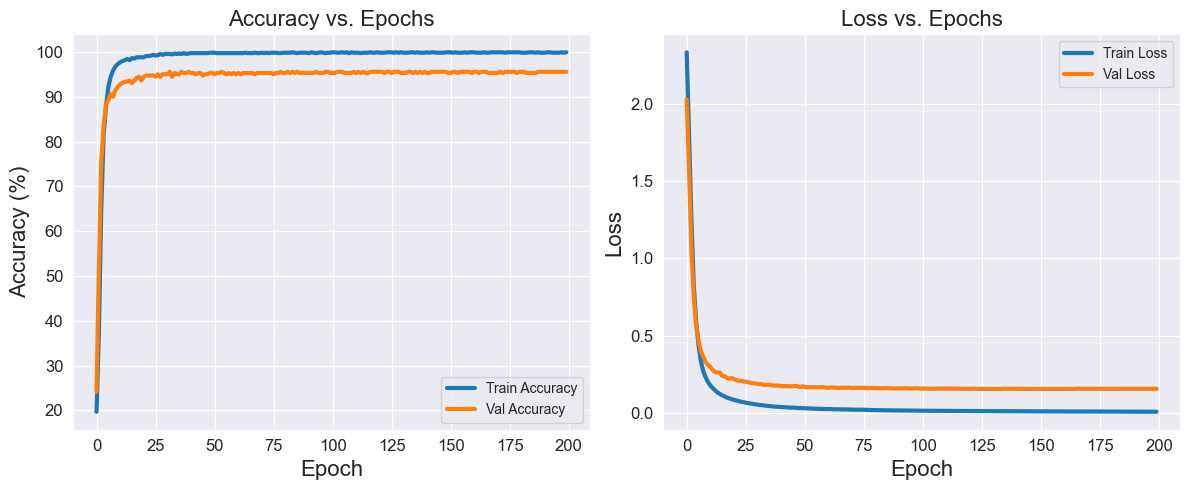

In [59]:
model.apply(uniform_init_parameters)
optimizer = optim.Adagrad(model.parameters(), lr=0.05)
result = fit_model(model, loss_fn, optimizer, epochs=200)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.0867, Train Acc: 98.70%, Val Loss: 0.2283, Val Acc: 93.61%
Epoch 20 / 100: Train Loss: 0.0285, Train Acc: 99.26%, Val Loss: 0.2074, Val Acc: 93.89%
Epoch 30 / 100: Train Loss: 0.0168, Train Acc: 99.72%, Val Loss: 0.2144, Val Acc: 94.17%
Epoch 40 / 100: Train Loss: 0.0091, Train Acc: 99.72%, Val Loss: 0.2179, Val Acc: 94.17%
Epoch 50 / 100: Train Loss: 0.0075, Train Acc: 99.81%, Val Loss: 0.2295, Val Acc: 94.72%
Epoch 60 / 100: Train Loss: 0.0061, Train Acc: 99.81%, Val Loss: 0.2232, Val Acc: 94.44%
Epoch 70 / 100: Train Loss: 0.0054, Train Acc: 99.72%, Val Loss: 0.2340, Val Acc: 94.17%
Epoch 80 / 100: Train Loss: 0.0109, Train Acc: 99.72%, Val Loss: 0.2447, Val Acc: 94.17%
Epoch 90 / 100: Train Loss: 0.0057, Train Acc: 99.72%, Val Loss: 0.2276, Val Acc: 94.17%
Epoch 100 / 100: Train Loss: 0.0067, Train Acc: 99.81%, Val Loss: 0.2413, Val Acc: 93.89%

Training complete!
Best Test Accuracy: 95.00% at epoch 23


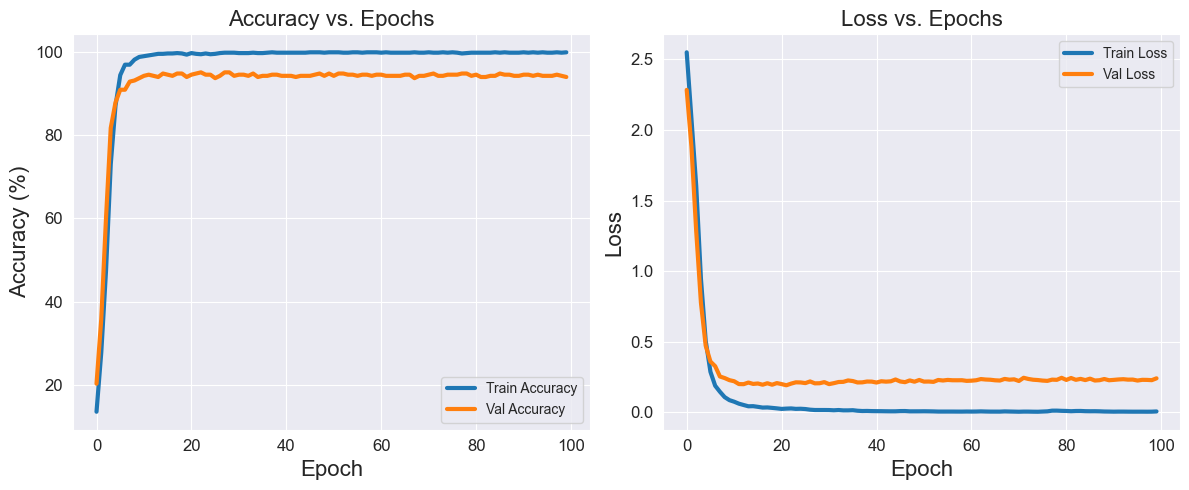

In [60]:
model.apply(uniform_init_parameters)
optimizer = optim.Adam(model.parameters(), lr=0.01)
result = fit_model(model, loss_fn, optimizer, epochs=100)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.0630, Train Acc: 98.89%, Val Loss: 0.1223, Val Acc: 96.39%
Epoch 20 / 100: Train Loss: 0.0201, Train Acc: 100.00%, Val Loss: 0.0936, Val Acc: 97.78%
Epoch 30 / 100: Train Loss: 0.0098, Train Acc: 100.00%, Val Loss: 0.0828, Val Acc: 98.06%
Epoch 40 / 100: Train Loss: 0.0061, Train Acc: 100.00%, Val Loss: 0.0755, Val Acc: 98.06%
Epoch 50 / 100: Train Loss: 0.0043, Train Acc: 100.00%, Val Loss: 0.0750, Val Acc: 97.78%
Epoch 60 / 100: Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.0737, Val Acc: 98.06%
Epoch 70 / 100: Train Loss: 0.0027, Train Acc: 100.00%, Val Loss: 0.0726, Val Acc: 98.06%
Epoch 80 / 100: Train Loss: 0.0023, Train Acc: 100.00%, Val Loss: 0.0720, Val Acc: 98.06%
Epoch 90 / 100: Train Loss: 0.0020, Train Acc: 100.00%, Val Loss: 0.0710, Val Acc: 98.06%
Epoch 100 / 100: Train Loss: 0.0017, Train Acc: 100.00%, Val Loss: 0.0708, Val Acc: 98.06%

Training complete!
Best Test Accuracy: 98.33% at epoch 31


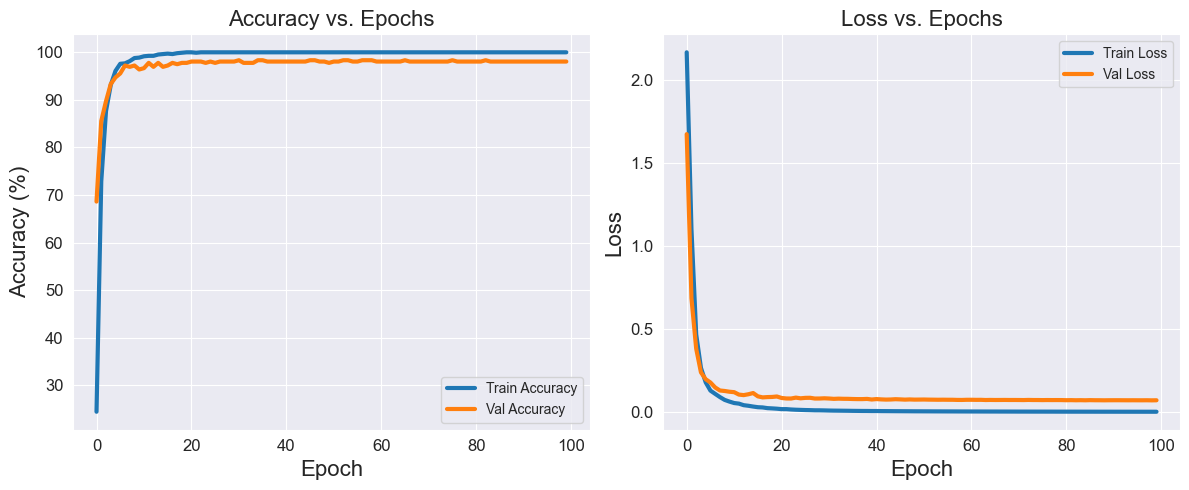

In [61]:
def xavier_init_parameters(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(xavier_init_parameters)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
result = fit_model(model, loss_fn, optimizer, epochs=100)
plot_results(result)

Epoch 20 / 200: Train Loss: 0.2112, Train Acc: 95.91%, Val Loss: 0.3449, Val Acc: 93.33%
Epoch 40 / 200: Train Loss: 0.0871, Train Acc: 99.07%, Val Loss: 0.2345, Val Acc: 94.44%
Epoch 60 / 200: Train Loss: 0.0498, Train Acc: 99.63%, Val Loss: 0.1988, Val Acc: 95.83%
Epoch 80 / 200: Train Loss: 0.0324, Train Acc: 99.72%, Val Loss: 0.1837, Val Acc: 96.11%
Epoch 100 / 200: Train Loss: 0.0230, Train Acc: 99.91%, Val Loss: 0.1746, Val Acc: 96.39%
Epoch 120 / 200: Train Loss: 0.0174, Train Acc: 100.00%, Val Loss: 0.1692, Val Acc: 96.67%
Epoch 140 / 200: Train Loss: 0.0136, Train Acc: 100.00%, Val Loss: 0.1658, Val Acc: 96.67%
Epoch 160 / 200: Train Loss: 0.0111, Train Acc: 100.00%, Val Loss: 0.1631, Val Acc: 97.22%
Epoch 180 / 200: Train Loss: 0.0093, Train Acc: 100.00%, Val Loss: 0.1610, Val Acc: 97.22%
Epoch 200 / 200: Train Loss: 0.0082, Train Acc: 100.00%, Val Loss: 0.1598, Val Acc: 97.22%

Training complete!
Best Test Accuracy: 97.22% at epoch 156


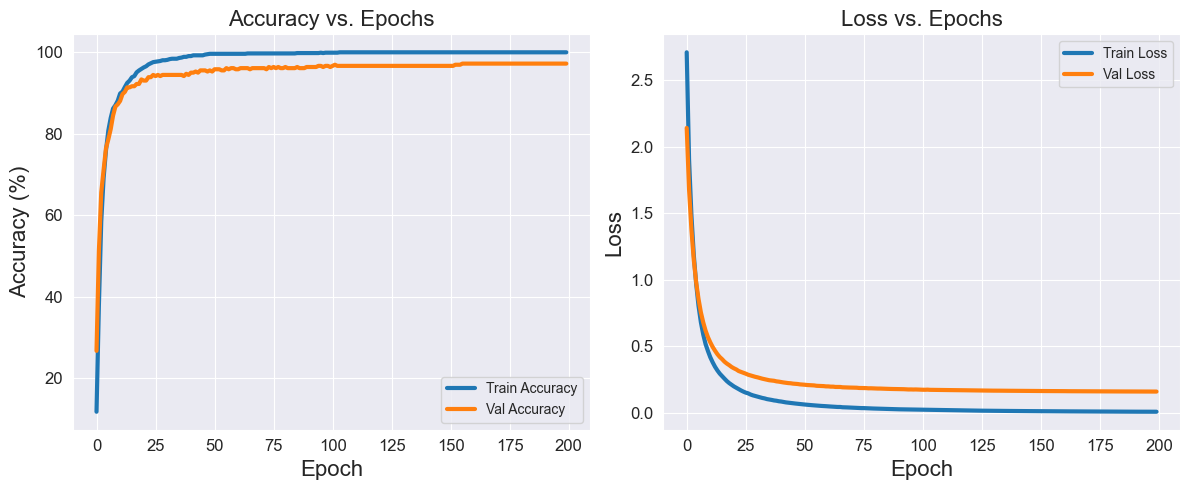

In [74]:
model2 = nn.Sequential(
    nn.Linear(64, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
)

def he_init_parameters(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model2.apply(he_init_parameters)
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
result = fit_model(model2, loss_fn, optimizer, epochs=200)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.0736, Train Acc: 98.51%, Val Loss: 0.1401, Val Acc: 96.39%
Epoch 20 / 100: Train Loss: 0.0434, Train Acc: 99.16%, Val Loss: 0.1310, Val Acc: 96.67%
Epoch 30 / 100: Train Loss: 0.0271, Train Acc: 99.26%, Val Loss: 0.1209, Val Acc: 96.67%
Epoch 40 / 100: Train Loss: 0.0079, Train Acc: 100.00%, Val Loss: 0.0807, Val Acc: 98.06%
Epoch 50 / 100: Train Loss: 0.0074, Train Acc: 99.91%, Val Loss: 0.0944, Val Acc: 98.06%
Epoch 60 / 100: Train Loss: 0.0059, Train Acc: 100.00%, Val Loss: 0.0943, Val Acc: 97.22%
Epoch 70 / 100: Train Loss: 0.0031, Train Acc: 100.00%, Val Loss: 0.0850, Val Acc: 97.78%
Epoch 80 / 100: Train Loss: 0.0027, Train Acc: 100.00%, Val Loss: 0.0889, Val Acc: 97.22%
Epoch 90 / 100: Train Loss: 0.0047, Train Acc: 99.91%, Val Loss: 0.0794, Val Acc: 97.78%
Epoch 100 / 100: Train Loss: 0.0054, Train Acc: 99.91%, Val Loss: 0.1082, Val Acc: 97.22%

Training complete!
Best Test Accuracy: 98.61% at epoch 36


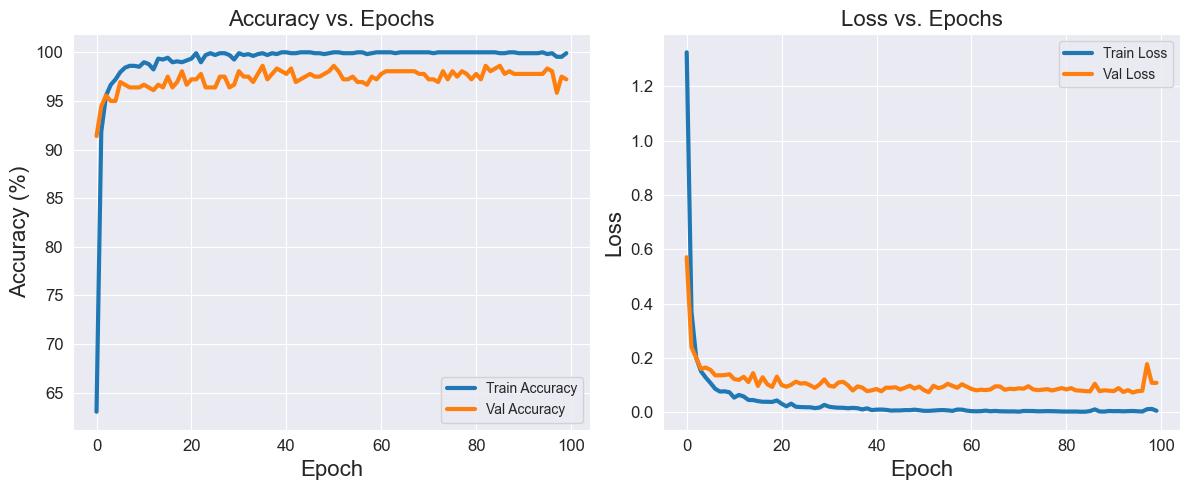

In [75]:
model3 = nn.Sequential(
    nn.Linear(64, 100),
    nn.BatchNorm1d(100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.Sigmoid(),
    nn.Linear(50, 10),
)

model3.apply(xavier_init_parameters)
optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
result = fit_model(model3, loss_fn, optimizer, epochs=100)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.4872, Train Acc: 93.04%, Val Loss: 0.5736, Val Acc: 89.17%
Epoch 20 / 100: Train Loss: 0.4540, Train Acc: 92.85%, Val Loss: 0.5011, Val Acc: 91.39%
Epoch 30 / 100: Train Loss: 0.4425, Train Acc: 92.94%, Val Loss: 0.4871, Val Acc: 91.94%
Epoch 40 / 100: Train Loss: 0.4406, Train Acc: 93.59%, Val Loss: 0.4650, Val Acc: 91.94%
Epoch 50 / 100: Train Loss: 0.4327, Train Acc: 93.31%, Val Loss: 0.4828, Val Acc: 90.28%
Epoch 60 / 100: Train Loss: 0.4362, Train Acc: 92.66%, Val Loss: 0.4540, Val Acc: 93.06%
Epoch 70 / 100: Train Loss: 0.4386, Train Acc: 93.13%, Val Loss: 0.4597, Val Acc: 92.22%
Epoch 80 / 100: Train Loss: 0.4332, Train Acc: 93.69%, Val Loss: 0.4606, Val Acc: 91.94%
Epoch 90 / 100: Train Loss: 0.4285, Train Acc: 93.13%, Val Loss: 0.4843, Val Acc: 92.22%
Epoch 100 / 100: Train Loss: 0.4309, Train Acc: 93.31%, Val Loss: 0.4610, Val Acc: 92.50%

Training complete!
Best Test Accuracy: 93.61% at epoch 56


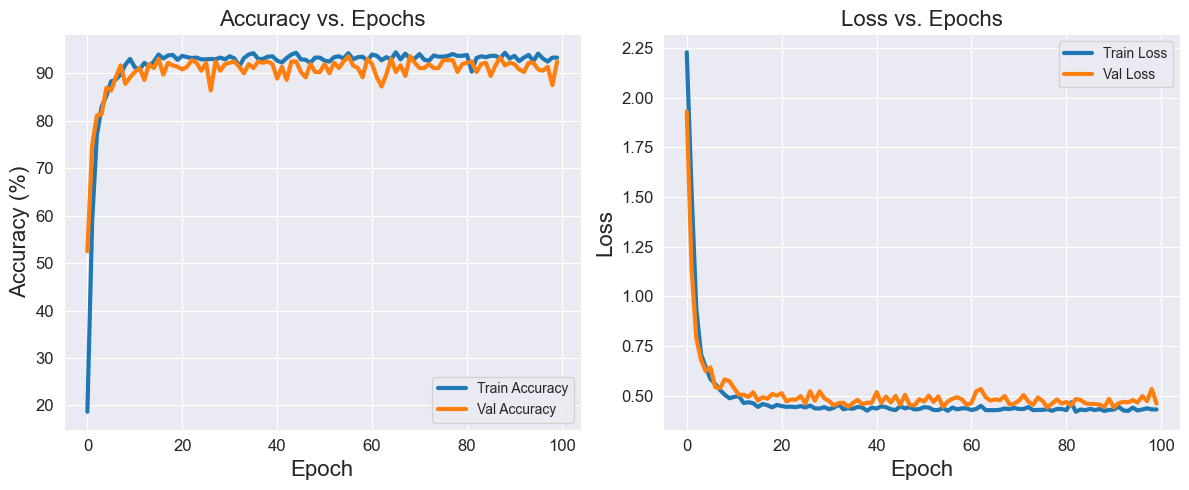

In [76]:
model.apply(xavier_init_parameters)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.01)
result = fit_model(model, loss_fn, optimizer, epochs=100)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.4589, Train Acc: 84.03%, Val Loss: 0.2242, Val Acc: 93.61%
Epoch 20 / 100: Train Loss: 0.2659, Train Acc: 90.62%, Val Loss: 0.1338, Val Acc: 94.17%
Epoch 30 / 100: Train Loss: 0.1944, Train Acc: 93.96%, Val Loss: 0.0926, Val Acc: 96.94%
Epoch 40 / 100: Train Loss: 0.2115, Train Acc: 94.15%, Val Loss: 0.1119, Val Acc: 95.56%
Epoch 50 / 100: Train Loss: 0.1522, Train Acc: 94.80%, Val Loss: 0.0882, Val Acc: 96.67%
Epoch 60 / 100: Train Loss: 0.1704, Train Acc: 94.71%, Val Loss: 0.0864, Val Acc: 96.67%
Epoch 70 / 100: Train Loss: 0.1400, Train Acc: 96.01%, Val Loss: 0.0903, Val Acc: 96.67%
Epoch 80 / 100: Train Loss: 0.1145, Train Acc: 96.47%, Val Loss: 0.0806, Val Acc: 96.67%
Epoch 90 / 100: Train Loss: 0.1044, Train Acc: 96.19%, Val Loss: 0.0722, Val Acc: 97.50%
Epoch 100 / 100: Train Loss: 0.1102, Train Acc: 95.82%, Val Loss: 0.0795, Val Acc: 96.39%

Training complete!
Best Test Accuracy: 98.06% at epoch 78


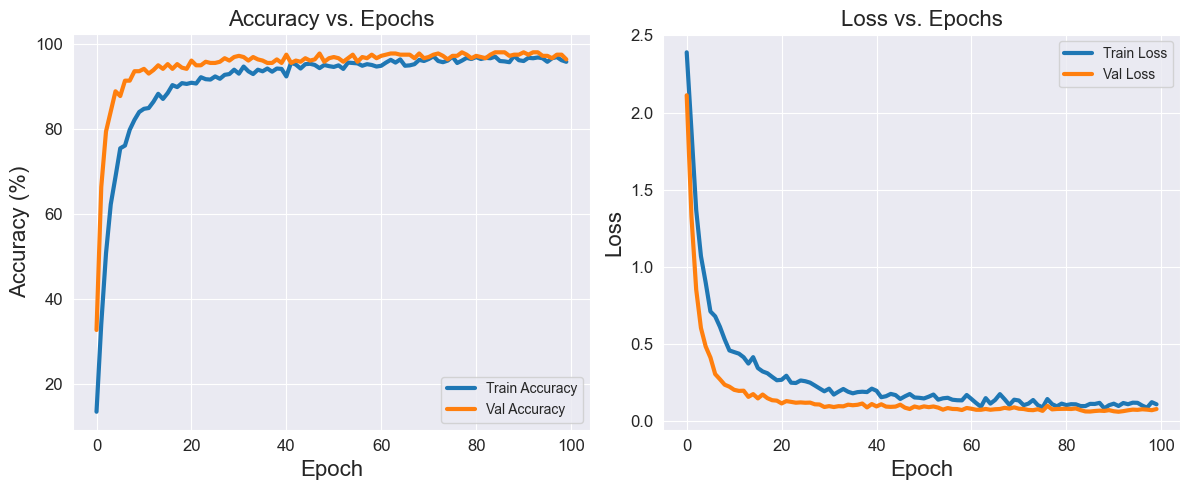

In [77]:
model4 = nn.Sequential(
    nn.Linear(64, 100),
    nn.Sigmoid(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 50),
    nn.Sigmoid(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 10),
)

model4.apply(xavier_init_parameters)
optimizer = optim.SGD(model4.parameters(), lr=0.1, momentum=0.9)
result = fit_model(model4, loss_fn, optimizer, epochs=100)
plot_results(result)

Epoch 10 / 100: Train Loss: 0.3613, Train Acc: 91.64%, Val Loss: 0.2761, Val Acc: 95.28%
Epoch 20 / 100: Train Loss: 0.1782, Train Acc: 95.36%, Val Loss: 0.1308, Val Acc: 98.33%
Epoch 30 / 100: Train Loss: 0.1010, Train Acc: 97.31%, Val Loss: 0.0843, Val Acc: 98.89%
Epoch 40 / 100: Train Loss: 0.0706, Train Acc: 98.05%, Val Loss: 0.0624, Val Acc: 98.89%
Epoch 50 / 100: Train Loss: 0.0553, Train Acc: 98.98%, Val Loss: 0.0440, Val Acc: 99.44%
Epoch 60 / 100: Train Loss: 0.0489, Train Acc: 98.79%, Val Loss: 0.0479, Val Acc: 98.33%
Epoch 70 / 100: Train Loss: 0.0343, Train Acc: 99.26%, Val Loss: 0.0378, Val Acc: 98.61%
Epoch 80 / 100: Train Loss: 0.0207, Train Acc: 99.54%, Val Loss: 0.0371, Val Acc: 99.17%
Epoch 90 / 100: Train Loss: 0.0276, Train Acc: 99.44%, Val Loss: 0.0363, Val Acc: 99.44%
Epoch 100 / 100: Train Loss: 0.0307, Train Acc: 98.98%, Val Loss: 0.0308, Val Acc: 99.17%

Training complete!
Best Test Accuracy: 99.44% at epoch 46


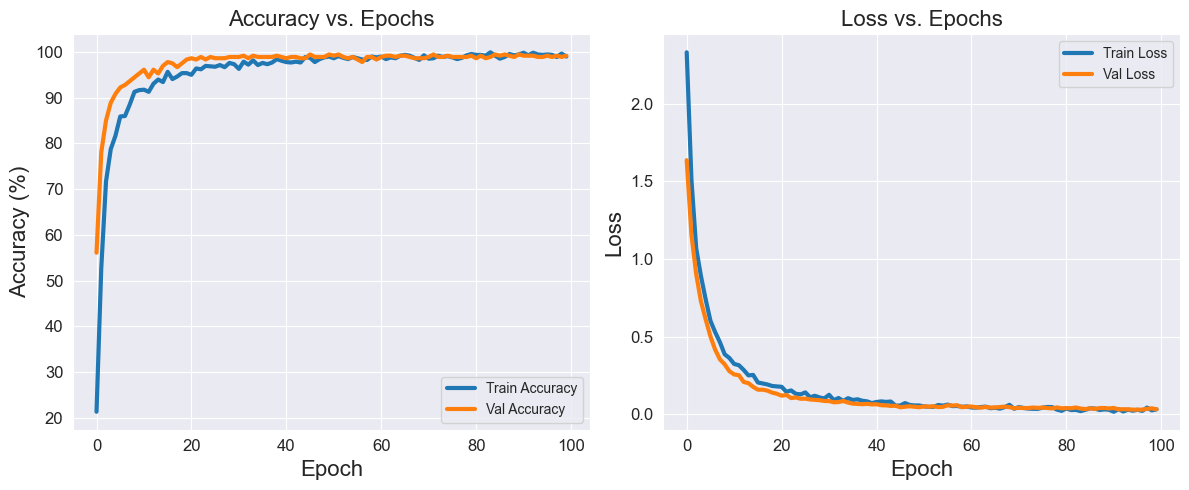

In [78]:
model_best = nn.Sequential(
    nn.Linear(64, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p=0.2),  
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Dropout(p=0.2), 
    nn.Linear(50, 10),
)

model_best.apply(he_init_parameters)
optimizer = optim.Adam(model_best.parameters(), lr=0.001)
result = fit_model(model_best, loss_fn, optimizer, epochs=100)
plot_results(result)

In [ ]:
evaluate_model(model_best, test_loader)

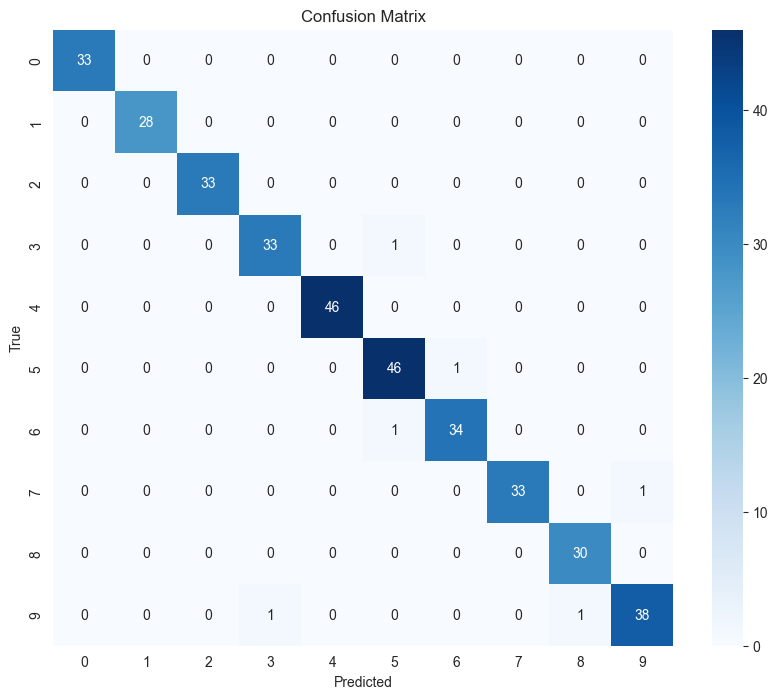

Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  1  0  0  0  0  1 38]]


In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model_with_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), 
                yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm

cm = evaluate_model_with_confusion_matrix(model_best, test_loader)
print("Confusion Matrix:")
print(cm)

In [90]:
def evaluate_with_errors(model, test_loader):
    model.eval()
    error_samples = []  # 存储所有错误样本的列表
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1) # 计算每个类别的概率
            _, preds = torch.max(outputs, 1)
            
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]
            for idx in wrong_indices:
                error_sample = {       
                    'features': inputs[idx].cpu().numpy().copy(),  
                    'true_label': labels[idx].item(),             
                    'pred_label': preds[idx].item(),             
                    'probabilities': outputs[idx].cpu().numpy().copy()
                }
                error_samples.append(error_sample)    
    return error_samples

error_data = evaluate_with_errors(model_best, test_loader)
print(f"\n总错误样本数: {len(error_data)}")


总错误样本数: 6


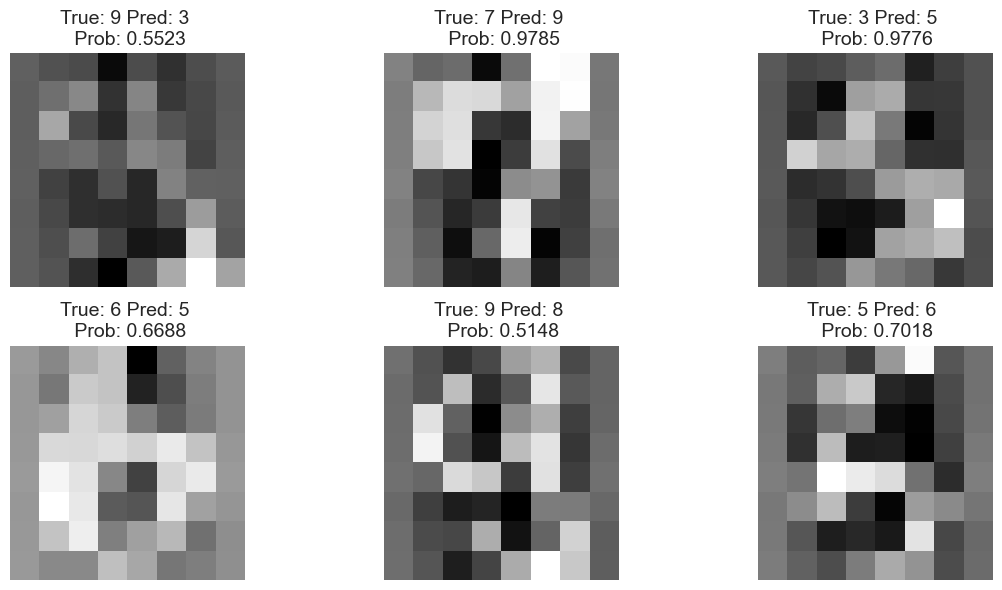

In [91]:
def plot_error_samples(error_data):
    num_samples = len(error_data)
    if num_samples == 0:
        print("No error samples to plot.")
        return
    
    max_cols = 3
    rows = (num_samples + max_cols - 1) // max_cols
    cols = min(num_samples, max_cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    for i in range(num_samples):
        row = i // max_cols
        col = i % max_cols
        ax = axes[row, col]
        
        sample = error_data[i]
        ax.imshow(sample['features'].reshape(8, 8), cmap='gray')
        ax.set_title(f"True: {sample['true_label']} Pred: {sample['pred_label']} \n Prob: {sample['probabilities'].max():.4f}" ,
                     fontsize=14)
        ax.axis('off')

    for i in range(num_samples, rows * cols):
        row = i // max_cols
        col = i % max_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

plot_error_samples(error_data)